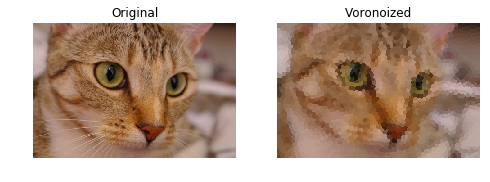

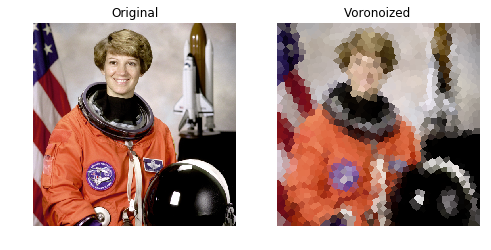

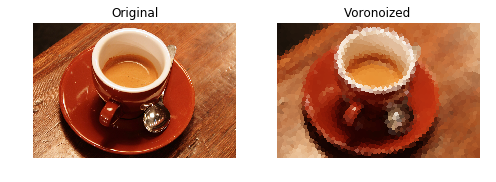

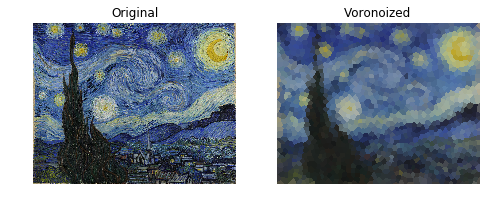

In [36]:
from scipy import sparse
from scipy.spatial import cKDTree
import skimage.data as data
from bridson import poisson_disc_samples
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def cartesian_prod(x, y):
    return np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])


class Voronoized:
    
    def __init__(self, image, density):
        self.original = image
        self.density = density
        self.transformed = None
        self.voronoize()
    
    def voronoize(self, density=None):
        if density is None:
            density = self.density
        assert(density > 0)

        nx, ny = self.original.shape[:2]
        radius = min(nx, ny) / density    

        # samples points evenly but not on a grid
        # https://bost.ocks.org/mike/algorithms/
        pts = np.asarray(poisson_disc_samples(nx, ny, radius))


        # https://stackoverflow.com/questions/45883314/python-check-and-count-how-many-where-points-sit-within-voronoi-cells
        voronoi_kdtree = cKDTree(pts)

        # make a grid of coords
        x = np.arange(nx)
        y = np.arange(ny)
        coords = cartesian_prod(x, y)
        # c_regions is an array mapping coords -> voronoi region #
        _, c_regions = voronoi_kdtree.query(coords)


        # copy image size
        self.transformed = np.zeros_like(self.original)

        for r in np.unique(c_regions):
            # mask for coords only in this voronoi region
            mask = np.where(c_regions == r)[0]

            # get the coords and create a mask for the copied image
            row = coords[mask][:, 0]
            col = coords[mask][:, 1]
            data = np.ones_like(row)
            # This is a fast way to go from coords -> mask
            im_mask = sparse.coo_matrix((data, (row, col)), 
                                        shape=self.transformed.shape[:2], 
                                        dtype=bool).toarray()

            # set the value of copied image at coords within this voronoi cell
            # to be the average of the colors in the original in the cell. 
            self.transformed[im_mask] = np.average(self.original[im_mask], axis=0)
        return self.transformed
    
    def show(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        ax1.axis('off')
        ax1.set_title('Original')
        ax1.imshow(self.original)

        ax2.imshow(self.transformed)
        ax2.axis('off')
        ax2.set_title('Voronoized')
        
        return fig, (ax1, ax2)
    
f, axes = Voronoized(data.chelsea(), 50).show()
f, axes = Voronoized(data.astronaut(), 50).show()
f, axes = Voronoized(data.coffee(), 50).show()
f, axes = Voronoized(plt.imread('Starry-Night.jpg'), 50).show()